In [1]:
# Missing values analysis for dynamic_supply_chain_logistics_dataset.csv

import os
import sys
from typing import List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

DATA_PATH = 'dynamic_supply_chain_logistics_dataset.csv'
assert os.path.exists(DATA_PATH), f"CSV not found at {DATA_PATH}"

print('Working directory:', os.getcwd())
print('File size (MB):', round(os.path.getsize(DATA_PATH) / (1024*1024), 2))


Working directory: d:\Projects\sudata_datathon
File size (MB): 14.77


In [2]:
# Load data with robust NA handling
# Treat common NA tokens as missing
na_tokens = [
    '', ' ', 'na', 'n/a', 'NA', 'N/A', 'null', 'NULL', 'none', 'None', 'nan', 'NaN', 'NAN', '-', '--'
]

dtypes = None  # Let pandas infer types; dataset is ~15MB, fits in memory

df = pd.read_csv(
    DATA_PATH,
    na_values=na_tokens,
    keep_default_na=True,
    low_memory=False
)

print('Rows, Cols:', df.shape)
df.head(3)


Rows, Cols: (32065, 26)


,timestamp,vehicle_gps_latitude,vehicle_gps_longitude,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,supplier_reliability_score,lead_time_days,historical_demand,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
0,2021-01-01 00:00:00,40.375568,-77.014318,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,0.359066,4.289160,456.503853,0.986064,2.128009,100.772854,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,Moderate Risk,9.110682
1,2021-01-01 01:00:00,33.507818,-117.036902,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,0.230660,7.018373,640.408205,0.463233,12.608166,5313.738114,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,High Risk,8.175281
2,2021-01-01 02:00:00,30.020640,-75.269224,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,0.027210,9.605064,155.749314,0.598561,14.124452,1595.049146,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,High Risk,1.283594


In [3]:
# Basic NA summary per column
na_counts = df.isna().sum()
na_pct = (na_counts / len(df) * 100).round(3)

summary = (
    pd.DataFrame({
        'dtype': df.dtypes.astype(str),
        'missing_count': na_counts,
        'missing_pct': na_pct
    })
    .sort_values('missing_pct', ascending=False)
)

summary


,dtype,missing_count,missing_pct
timestamp,object,0,0.0
vehicle_gps_latitude,float64,0,0.0
risk_classification,object,0,0.0
delay_probability,float64,0,0.0
disruption_likelihood_score,float64,0,0.0
fatigue_monitoring_score,float64,0,0.0
driver_behavior_score,float64,0,0.0
customs_clearance_time,float64,0,0.0
route_risk_level,float64,0,0.0
cargo_condition_status,float64,0,0.0


In [4]:
# Extended NA-like patterns check (e.g., whitespace-only strings)
# Build a per-column diagnostic for unusual tokens
from collections import Counter

def detect_special_tokens(series: pd.Series, sample_limit: int = 10) -> Dict[str, int]:
    if series.dtype == 'O':  # object/string
        tokens = series.dropna().astype(str).str.strip()
        unusual = tokens[tokens.isin(['', 'NA', 'N/A', 'na', 'n/a', 'null', 'NULL', 'None', 'none', '-', '--'])]
        return Counter(unusual)
    return {}

special_token_report: Dict[str, Dict[str, int]] = {}
for col in df.columns:
    special_token_report[col] = detect_special_tokens(df[col])

{k: v for k, v in special_token_report.items() if len(v) > 0}


{}

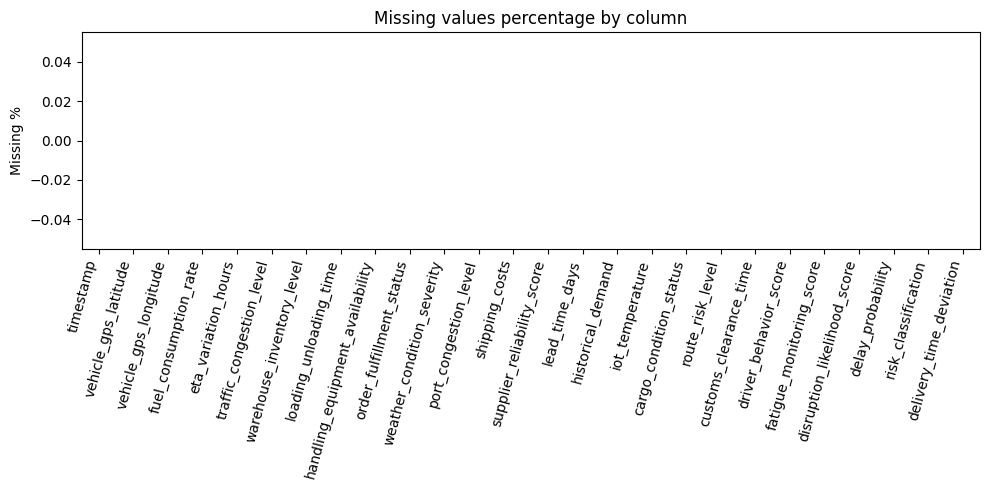

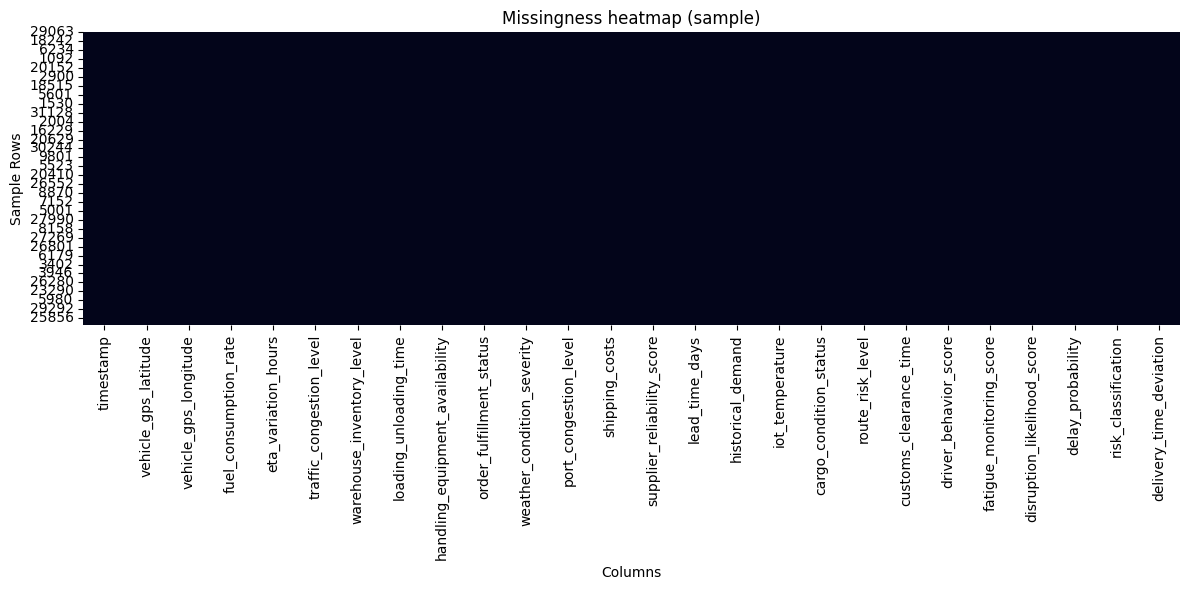

In [5]:
# Visualize missingness
plt.figure(figsize=(10, 5))
ax = (summary['missing_pct']
      .sort_values(ascending=False)
      .plot(kind='bar', color='#4C78A8'))
plt.ylabel('Missing %')
plt.title('Missing values percentage by column')
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.show()

# Heatmap of missingness pattern for a sample
sample = df.sample(min(2000, len(df)), random_state=42)
plt.figure(figsize=(12, 6))
sns.heatmap(sample.isna(), cbar=False)
plt.title('Missingness heatmap (sample)')
plt.xlabel('Columns')
plt.ylabel('Sample Rows')
plt.tight_layout()
plt.show()


In [6]:
# Quick integrity checks for key fields
checks = {}
checks['timestamp_non_null'] = df['timestamp'].notna().all()
checks['risk_classification_unique'] = sorted(df['risk_classification'].dropna().unique().tolist())
checks['rows'] = len(df)
checks['cols'] = df.shape[1]
checks


{'timestamp_non_null': True,
 'risk_classification_unique': ['High Risk', 'Low Risk', 'Moderate Risk'],
 'rows': 32065,
 'cols': 26}

## Handling Missing Data: Strategy and Assumptions

This section implements a transparent imputation workflow tailored for the dataset:

- Time-series aware numeric imputation:
  - Interpolate within series (time-based, linear), then forward/backward fill edges.
- Categorical/object imputation:
  - Fill with mode (most frequent).
- Domain logic rule:
  - If `handling_equipment_availability` is NA while `loading_unloading_time` indicates delays (>= 75th percentile), set availability to 0.0 ("not available").
- Optional model-based imputation:
  - KNNImputer for remaining numeric gaps after the above steps. Disabled by default.

Assumptions to document:
- Timestamps are hourly, monotonic per dataset. Interpolation assumes smooth variation across adjacent hours.
- Mode for categoricals is acceptable given limited category cardinality (`risk_classification` has few levels).
- The domain rule reflects likelihood that equipment unavailability coincides with long handling times.
- No row drops; only imputations are applied. A change log is generated for transparency.


In [ ]:
# Prepare datetime index for time-aware methods
_df = df.copy()
_df['timestamp'] = pd.to_datetime(_df['timestamp'], errors='coerce')
_df = _df.sort_values('timestamp').set_index('timestamp')

# Identify numeric vs categorical columns
numeric_cols = _df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in _df.columns if c not in numeric_cols]

print('Numeric columns:', len(numeric_cols))
print('Categorical columns:', len(cat_cols))
_df.head(2)


In [ ]:
# Time-series numeric imputation: interpolate, then edge fill
_imputed_numeric = _df[numeric_cols].copy()

# Linear interpolation along the time index
_imputed_numeric = _imputed_numeric.interpolate(method='time', limit_direction='both')
# Edge fill lingering gaps
_imputed_numeric = _imputed_numeric.ffill().bfill()

# Categorical imputation: mode fill
_imputed_cat = _df[cat_cols].copy()
for col in _imputed_cat.columns:
    if _imputed_cat[col].isna().any():
        mode_val = _imputed_cat[col].mode(dropna=True)
        if len(mode_val) > 0:
            _imputed_cat[col] = _imputed_cat[col].fillna(mode_val.iloc[0])
        else:
            _imputed_cat[col] = _imputed_cat[col].fillna('UNKNOWN')

# Combine
imputed_df = pd.concat([_imputed_numeric, _imputed_cat], axis=1).sort_index()
imputed_df = imputed_df[_df.columns]  # original column order

print('Remaining NA after TS+mode:', int(imputed_df.isna().sum().sum()))


In [ ]:
# Domain logic rule: handling_equipment_availability
col_avail = 'handling_equipment_availability'
col_handling = 'loading_unloading_time'

if col_avail in imputed_df.columns and col_handling in imputed_df.columns:
    delay_threshold = _df[col_handling].quantile(0.75)  # 75th percentile as 'delay'
    to_fill_idx = imputed_df[col_avail].isna() & (_df[col_handling] >= delay_threshold)
    filled_count = int(to_fill_idx.sum())
    imputed_df.loc[to_fill_idx, col_avail] = 0.0
    print(f"Domain rule applied to {filled_count} rows: set {col_avail}=0.0 when {col_handling} >= {delay_threshold:.3f}")
else:
    print('Domain rule skipped: columns missing')


In [ ]:
# Optional: KNN imputation for any remaining numeric gaps
# Disabled by default to keep dependencies light and runtime reasonable
USE_KNN = False

if USE_KNN:
    from sklearn.impute import KNNImputer
    knn_cols = numeric_cols
    knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
    knn_values = knn_imputer.fit_transform(imputed_df[knn_cols])
    imputed_df.loc[:, knn_cols] = knn_values
    print('KNN imputation applied.')
else:
    print('KNN imputation skipped. Set USE_KNN=True to enable.')


In [ ]:
# Report: before vs after missingness
before = df.isna().sum()
after = imputed_df.reset_index().isna().sum()  # reset index to treat timestamp explicitly

report = pd.DataFrame({
    'before_missing': before,
    'after_missing': after.reindex(before.index, fill_value=0)
})
report['delta'] = report['before_missing'] - report['after_missing']
report.sort_values('delta', ascending=False)


In [ ]:
# Save imputed dataset (optional)
OUTPUT_PATH = 'dynamic_supply_chain_logistics_dataset_imputed.csv'
imputed_export = imputed_df.reset_index()  # bring timestamp back as a column
imputed_export.to_csv(OUTPUT_PATH, index=False)

print('Saved to:', OUTPUT_PATH)
print('Rows, Cols:', imputed_export.shape)
